Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from glob import glob

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
dir_train = '/content/gdrive/MyDrive/CNN_Dataset/Train'
dir_test = '/content/gdrive/MyDrive/CNN_Dataset/Test'
dir_aug = '/content/gdrive/MyDrive/CNN_Dataset/Aug_Train'

data_dir_train = pathlib.Path(dir_train)
data_dir_test = pathlib.Path(dir_test)

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

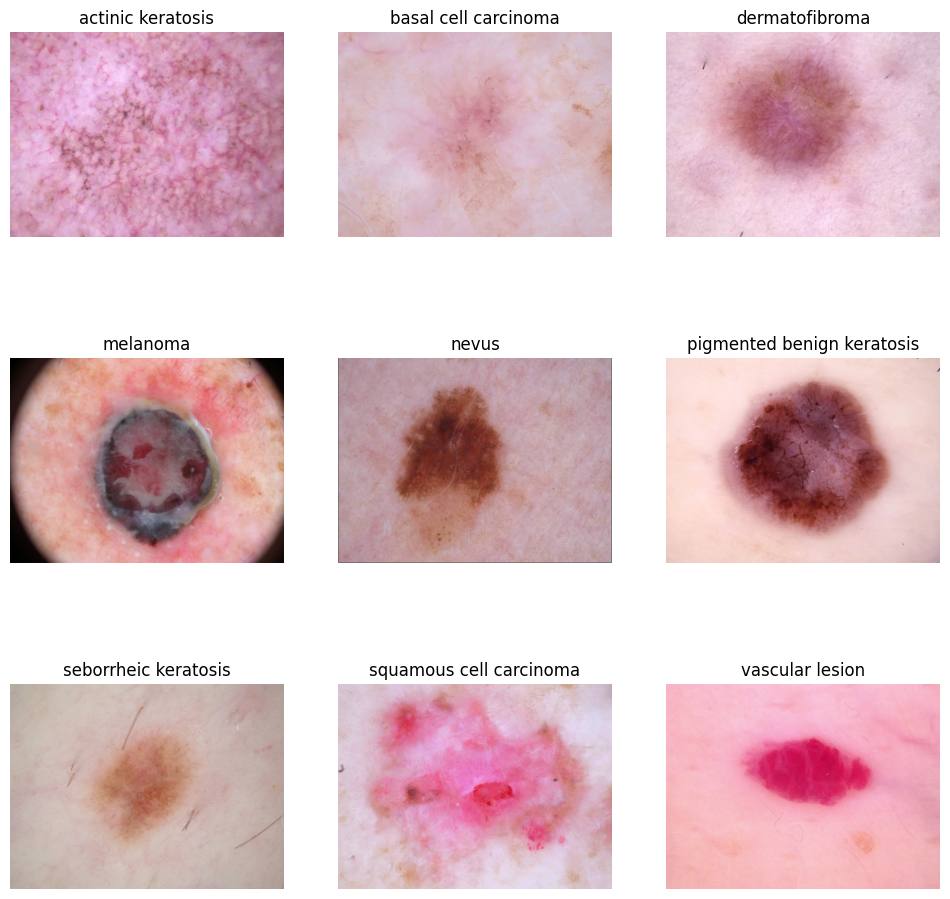

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12, 12))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,BatchNormalization,Flatten,Dense

### Your code goes here
model = Sequential()
# rescaling pixel values
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size=(7, 7),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function

from keras.callbacks import ReduceLROnPlateau
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=4,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 45, 45, 32)       

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 79s 90ms/step - loss: 1.9096 - accuracy: 0.2377 - val_loss: 1.6010 - val_accuracy: 0.3899
Epoch 2/20
281/281 [==============================] - 13s 45ms/step - loss: 1.5595 - accuracy: 0.3887 - val_loss: 1.6321 - val_accuracy: 0.3591
Epoch 3/20
281/281 [==============================] - 13s 45ms/step - loss: 1.3938 - accuracy: 0.4532 - val_loss: 1.4019 - val_accuracy: 0.4566
Epoch 4/20
281/281 [==============================] - 13s 45ms/step - loss: 1.2589 - accuracy: 0.5044 - val_loss: 1.1107 - val_accuracy: 0.5585
Epoch 5/20
281/281 [==============================] - 14s 50ms/step - loss: 1.1132 - accuracy: 0.5663 - val_loss: 0.9793 - val_accuracy: 0.6208
Epoch 6/20
281/281 [==============================] - 13s 45ms/step - loss: 0.9931 - accuracy: 0.6200 - val_loss: 0.8606 - val_accuracy: 0.7014
Epoch 7/20
281/281 [==============================] - 13s 46ms/step - loss: 0.8607 - accuracy: 0.6694 - val_loss: 0.7524 - val_accuracy:

### Visualizing training results

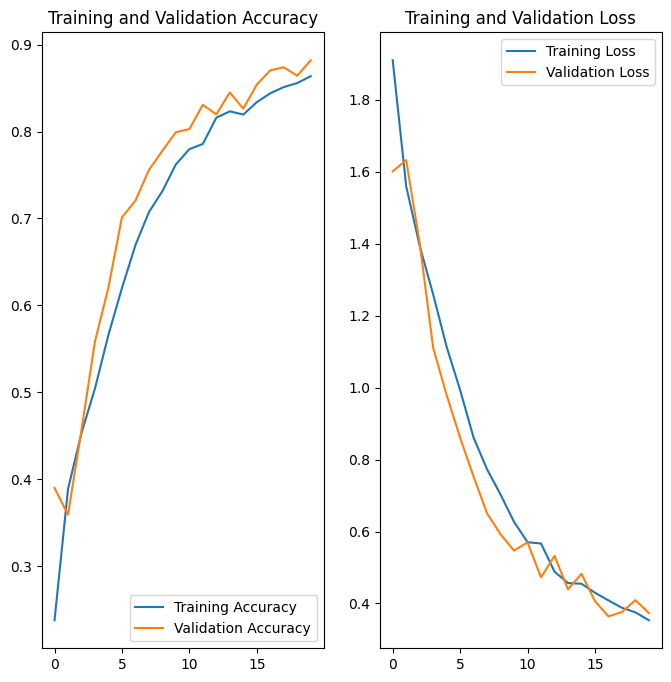

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

###### Findings:

- The training accuracy and validation accuracy were increasing simultaneously till epoch 12. But after that, the validation accuracy was not increasing although training accuracy was increasing. This suggests a slight overfitting.
- The training accuracy did not exceed 0.62 hence there is need to provide more dataset as well.
- Training loss keeps on getting low but validation loss was not getting low after epoch 12.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3),seed=123),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.3),
    layers.experimental.preprocessing.RandomContrast(0.3)
  ]
)

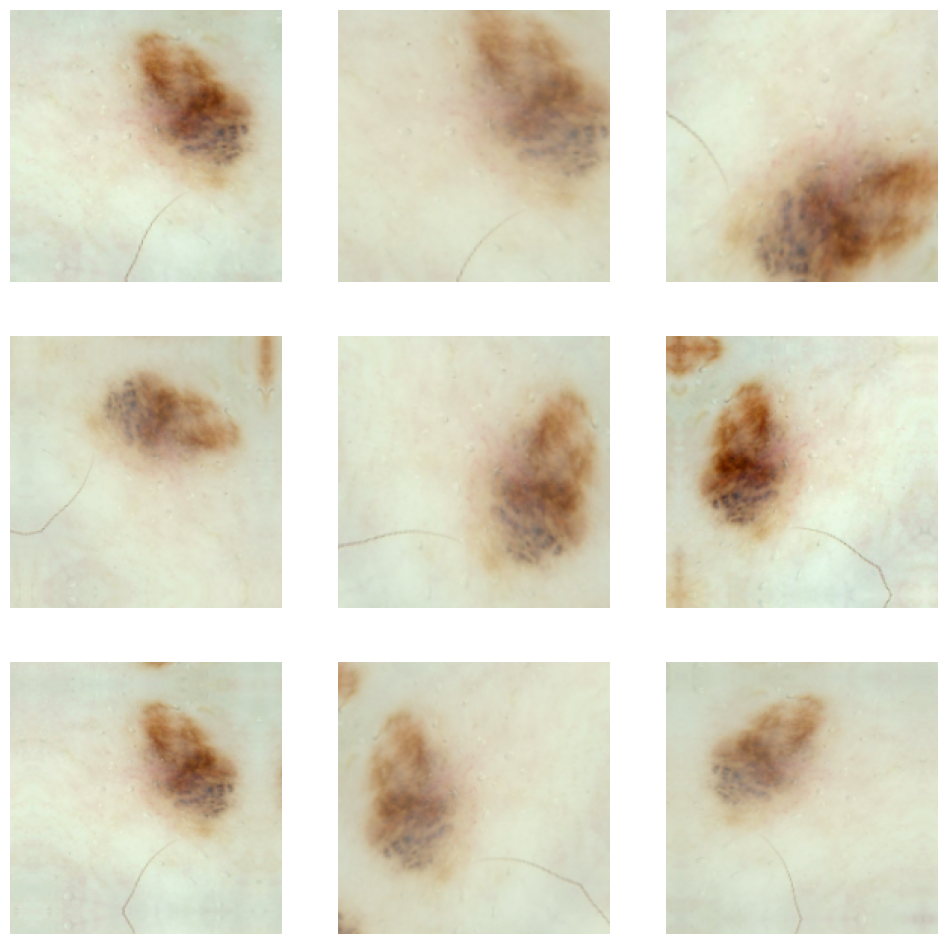

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(20):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()
# rescaling pixel values
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# adding data augmentation
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size=(7, 7),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compiling the model

In [ ]:
## Your code goes here

from keras.callbacks import ReduceLROnPlateau
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=4,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
281/281 [==============================] - 17s 49ms/step - loss: 1.9128 - accuracy: 0.2599 - val_loss: 1.6914 - val_accuracy: 0.3284 - lr: 0.0010
Epoch 2/20
281/281 [==============================] - 13s 48ms/step - loss: 1.6203 - accuracy: 0.3565 - val_loss: 1.4429 - val_accuracy: 0.4148 - lr: 0.0010
Epoch 3/20
281/281 [==============================] - 13s 48ms/step - loss: 1.5173 - accuracy: 0.3985 - val_loss: 1.5224 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 4/20
281/281 [==============================] - 14s 49ms/step - loss: 1.4814 - accuracy: 0.4192 - val_loss: 1.3582 - val_accuracy: 0.4459 - lr: 0.0010
Epoch 5/20
281/281 [==============================] - 13s 48ms/step - loss: 1.4451 - accuracy: 0.4305 - val_loss: 1.4114 - val_accuracy: 0.4682 - lr: 0.0010
Epoch 6/20
281/281 [==============================] - 13s 48ms/step - loss: 1.4032 - accuracy: 0.4435 - val_loss: 1.2842 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 7/20
281/281 [==============================] - 13s 

### Visualizing the results

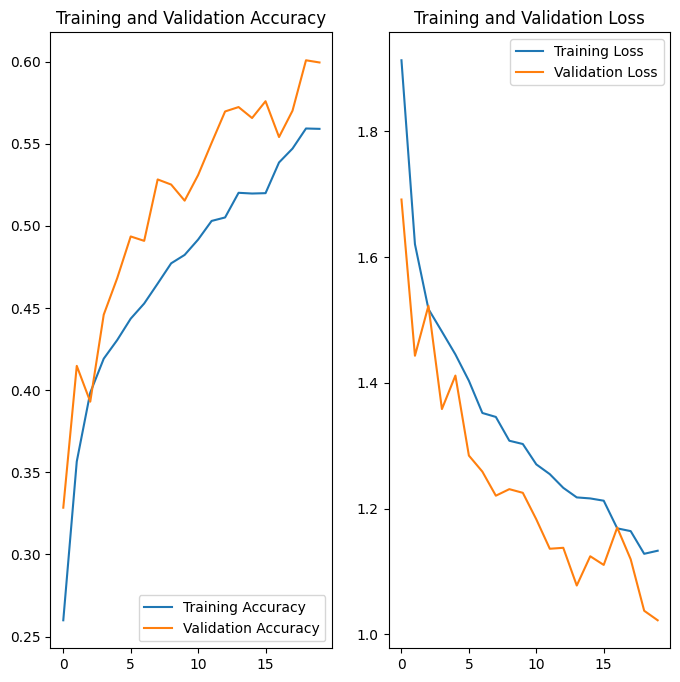

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

##### Findings

- Both training and validation accuracy are increasing with number of epochs but there is fluctuation in validation dataset.
- The training loss is decreasing but there is a big fluctuation in validation loss.
- Overfitting issue is resolved.
- The training accuracy is still less hence this is an indication of underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

<ipython-input-39-977974911cda>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-39-977974911cda>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-39-977974911cda>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-39-977974911cda>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipy

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

seborrheic keratosis 77

#### - Which classes dominate the data in terms proportionate number of samples?

pigmented benign keratosis 462

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset = dir_train + "/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD2A80B1EA0>: 100%|██████████| 500/500 [00:19<00:00, 25.98 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD290DFE9E0>: 100%|██████████| 500/500 [00:21<00:00, 23.11 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD2A80B1DE0>: 100%|██████████| 500/500 [00:24<00:00, 20.80 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7AD2B061CC70>: 100%|██████████| 500/500 [01:19<00:00,  6.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7AD290E633A0>: 100%|██████████| 500/500 [01:27<00:00,  5.71 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD2B0091600>: 100%|██████████| 500/500 [00:19<00:00, 25.29 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AD2B3443B50>: 100%|██████████| 500/500 [00:38<00:00, 12.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD2B3413B50>: 100%|██████████| 500/500 [00:16<00:00, 30.14 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD2DD31FB20>: 100%|██████████| 500/500 [00:17<00:00, 29.08 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict = dict(zip(path_list, lesion_list))
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-46-896e00220f47>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Copy augmented data to new directory with orignal data

---



In [ ]:
import shutil

org_dir = dir_train + '/'
aug_dir = dir_aug + '/'

# Copy all images to a new folder

shutil.copytree(org_dir, aug_dir)

In [ ]:
# Merge augmentor output files with original images
for x in class_names:
  src_dir = aug_dir + x + '/output/'
  des_dir = aug_dir + x
  print('Source --> ', src_dir)
  print('Destination --> ', des_dir)

  files = os.listdir(src_dir)
  for file in files:
    file_name = os.path.join(src_dir, file)
    shutil.move(file_name, des_dir)

  # remove the output directory
  shutil.rmtree(src_dir)

In [ ]:
aug_data = pathlib.Path(dir_train + '/')
image_count_aug = len(list(aug_data.glob('*/*.jpg')))
print(image_count_aug)

11239


#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/CNN_Data/Aug_Train/')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode = 'categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model_final = keras.Sequential([
 tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0),

 keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(img_height,img_width,3), padding='same'),
 keras.layers.MaxPooling2D(2,2),
 keras.layers.Dropout(0.2),

 keras.layers.Conv2D(64,(3,3), activation='relu', padding='same'),
 keras.layers.MaxPooling2D(2,2),
 keras.layers.Dropout(0.2),

 keras.layers.Conv2D(128,(3,3), activation='relu', padding='same'),
 keras.layers.MaxPooling2D(2,2),
 keras.layers.Dropout(0.2),

 keras.layers.Flatten(),
 keras.layers.Dense(128,activation = 'relu'),
 keras.layers.Dropout(0.25),
 keras.layers.Dense(9,activation = 'softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
# TODO: epochs = 50

history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/30
281/281 [==============================] - 75s 241ms/step - loss: 2.2583 - accuracy: 0.1191 - val_loss: 2.1912 - val_accuracy: 0.1331
Epoch 2/30
281/281 [==============================] - 64s 222ms/step - loss: 2.1724 - accuracy: 0.1437 - val_loss: 2.1663 - val_accuracy: 0.1611
Epoch 3/30
281/281 [==============================] - 62s 217ms/step - loss: 1.9023 - accuracy: 0.2611 - val_loss: 1.5995 - val_accuracy: 0.3916
Epoch 4/30
281/281 [==============================] - 63s 221ms/step - loss: 1.4507 - accuracy: 0.4424 - val_loss: 1.3509 - val_accuracy: 0.4913
Epoch 5/30
281/281 [==============================] - 64s 222ms/step - loss: 1.1793 - accuracy: 0.5591 - val_loss: 1.0550 - val_accuracy: 0.6297
Epoch 6/30
281/281 [==============================] - 63s 220ms/step - loss: 0.9936 - accuracy: 0.6341 - val_loss: 1.0444 - val_accuracy: 0.6333
Epoch 7/30
281/281 [==============================] - 60s 210ms/step - loss: 0.7938 - accuracy: 0.7042 - val_loss: 0.7682 - val_ac

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

